In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Estimator

In [3]:
class Estimator:
    def __init__(self,bins=None,lam=None):
        self.bins = bins
        self.lam = lam

    def set_bins_params(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        self.val_min = val_min
        self.width = width

    def fit(self,val,residual,p):
        self.set_bins_params(val)
        index = self.get_index(val)

        residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))
        
        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin
        
        grads = self.get_grads(index)

        return grads


    def get_index(self,val):
        index = ((val - self.val_min)//self.width).astype('int32') if self.width !=0 else np.zeros(val.shape[0])
        index = np.where(index >= self.bins,self.bins-1,index)
        index = np.where(index < 0,0,index)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Decision Tree Estimator

In [4]:
class Estimator_DC:
    def __init__(self,max_depth=None,lam=None):
        self.max_depth = max_depth
        self.lam = lam

    def set_grads_bin(self,residual,p):
        residual_bin = np.stack([np.sum(residual[self.index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[self.index==i],1-p[self.index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))

        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin

        return self.get_grads(self.index)

    def fit(self,val,y):
        val = val.reshape(-1,1)

        self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight='balanced')
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight={0:1,1:1,2:1})
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth)
        self.clf.fit(val,y)
        self.index = self.get_index(val)
        
        self.bins = len(self.clf.tree_.threshold)

    # def get_loss(self,base_gini):
    #     self.loss = -(base_gini - np.sum(self.clf.tree_.impurity))

    #     return self.loss

    def get_loss(self):
        impurity = self.clf.tree_.impurity[self.clf.tree_.children_right == -1]
        weighted_node = self.clf.tree_.weighted_n_node_samples[self.clf.tree_.children_right == -1]

        self.loss = impurity@(weighted_node/sum(weighted_node))

        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.weighted_n_node_samples/sum(self.clf.tree_.weighted_n_node_samples))
        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.n_node_samples/sum(self.clf.tree_.n_node_samples))
        return self.loss

    # def get_loss(self,grads,log_odds,p,learning_rate):
        # log_odds_1 = log_odds + learning_rate * grads
        
        # p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
        # p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
        
        # self.loss = np.sum(np.power(self.Y - p_1,2))
        # self.loss = -np.sum(np.power(self.p - p_1,2))
        # self.loss = -np.sum(np.abs(grads))
    #     return self.loss

    def get_index(self,val):
        val = val.reshape(-1,1)
        index = self.clf.apply(val)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Node

In [5]:
class Node:
    def __init__(self,terminal,func=None,sons=None,index=None,fit=None,estimator=None):
        self.terminal = terminal
        self.sons = sons
        self.func = func
        self.index = index
        self.fitness = fit
        self.estimator = estimator
        if self.terminal:
            self.depth = 0
            self.numNode = 1
        else:
            self.depth = max([s.depth for s in sons]) + 1
            self.numNode = sum([s.numNode for s in sons])+ 1

    def predict_grad(self,X):
        val = self.predict_val(X)
        return self.estimator.predict_grad(val)
        
    def predict_val(self,X):
        X = X.astype('float64')
        return self.pred_rec(X.T)
    def pred_rec(self,X):
        if not self.terminal:
            return self.func([s.pred_rec(X) for s in self.sons])
        else:
            return X[self.index]
    def __str__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string
    def __repr__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string

# Engine

In [6]:
class Engine:
    def __init__(self,opset,X,Y,Y_one_hot,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y
        self.Y_one_hot = Y_one_hot

        base_gini = (pd.value_counts(y_train)/y_train.shape)
        self.base_gini = sum(base_gini*(1-base_gini))

        self.log_odds = log_odds
        self.p = p
        self.residual = Y_one_hot - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    # def calculate_grad(self,val,lam):
    #     bins = self.bins
    #     val_max = np.max(val)
    #     val_min = np.min(val)
    #     width = ((val_max - val_min)/bins)

    #     index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
    #     index = np.where(index >= bins,bins-1,index)
    #     index = np.where(index < 0,0,index)

    #     residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
    #     p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)]) + lam
    #     grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    #     grads = np.zeros(self.log_odds.shape)
    #     for i in range(bins):
    #         grads[index==i] = grad_bin[i]
            
    #     return grads

    
    def calculate_fitness(self,vals,lam=0,max_depth=3):
        fitness = []
        estimators = []
        for val in vals:
            # est = Estimator(self.bins,lam)
            # grads = est.fit(val,self.residual,self.p)
            est = Estimator_DC(max_depth,lam)
            est.fit(val,self.Y)

            # grads = est.set_grads_bin(self.residual,self.p)
            # loss = est.get_loss(grads,self.log_odds,self.p,self.learning_rate)

            # loss = est.get_loss(self.base_gini)
            
            loss = est.get_loss()
            
            fitness.append(loss)
            estimators.append(est)

        return fitness,estimators
    

    def evolve(self,total_size,batch_size,elite_size,lam=0,max_depth=3,verbose=0):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        elites_estimator = []

        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,estimators = self.calculate_fitness(vals,lam,max_depth)
            # fitness = self.calculate_decision(vals,1,lam)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)
            elites_estimator.extend(estimators)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]
            elites_estimator = [elites_estimator[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index],
                estimator=elites_estimator[index]
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict_val(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

# Stack

In [7]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [8]:
def adding_unique_node(stack,losses,new_nodes,tolerance):
    protect_losses = [-np.inf] + losses + [np.inf]
    protect_stack = [None] + stack + [None]
    new_losses = [ node.estimator.loss for node in new_nodes]

    for i in range(len(new_losses)):
        new_loss = new_losses[i]
        new_node = new_nodes[i]
        
        index = np.searchsorted(protect_losses,new_loss,side='left')
        left_index = index - 1
        right_index = index 

        left_diff = new_loss - protect_losses[left_index]
        left_node = protect_stack[left_index]

        right_diff = protect_losses[right_index] - new_loss
        right_node = protect_stack[right_index]

        mid_flag,left_flag,right_flag = (1,1,1)

        if left_diff < tolerance:
            if left_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                left_flag = 0
        if right_diff < tolerance:
            if right_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                right_flag = 0
        
        if mid_flag == 1:
            if right_flag == 0:
                protect_stack.pop(right_index)
                protect_losses.pop(right_index)
                
            protect_stack.insert(index,new_node)
            protect_losses.insert(index,new_loss)

            if left_flag == 0:
                protect_stack.pop(left_index)
                protect_losses.pop(left_index)
    
    losses = protect_losses[1:-1]
    stack = protect_stack[1:-1]

    return stack,losses

In [9]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Data

In [10]:
df = pd.read_csv("../data/sleep.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")
y[y==5] = 4

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [94]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

learning_rate = 0.3
lam = 1
max_depth = 3
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]

In [95]:
tolerance = min([losses[i] - losses[i-1] for i in range(1,len(losses))])/10
# tolerance = 0.000001
i = 0

epoch = 10

total = 10
elite = 3


while sum([n.numNode for n in stack]) < 100000:
        eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
        for j in range(epoch):
                eg.evolve(total,total,elite,lam,max_depth,0)
        # s.extend([eg.best[1]])
        newcomers = eg.nodes[-elite*epoch:]
        stack,losses = adding_unique_node(stack,losses,newcomers,tolerance)

        print(i,len(stack),sum([n.numNode for n in stack]))
        i += 1

0 43 293
1 71 527
2 98 766
3 126 974
4 147 1133
5 169 1343
6 196 1694
7 225 1923
8 249 2135
9 273 2349
10 296 2628
11 315 2781
12 338 3004
13 359 3149
14 378 3320
15 401 3483
16 418 3630
17 440 3866
18 458 4034
19 485 4329
20 507 4523
21 526 4854
22 549 5075
23 570 5246
24 593 5433
25 611 5611
26 634 5760
27 654 5978
28 675 6267
29 696 6462
30 712 6608
31 734 6782
32 749 6925
33 767 7099
34 785 7251
35 804 7428
36 826 7640
37 842 7774
38 859 7885
39 881 8103
40 900 8260
41 920 8544
42 940 8748
43 953 8867
44 969 8999
45 988 9152
46 1007 9319
47 1026 9500
48 1043 9605
49 1060 9744
50 1072 9910
51 1085 10013
52 1102 10148
53 1118 10268
54 1137 10439
55 1152 10582
56 1167 10671
57 1185 10871
58 1202 11048
59 1222 11278
60 1233 11361
61 1253 11509
62 1269 11677
63 1284 11802
64 1298 11912
65 1318 12078
66 1328 12138
67 1338 12264
68 1355 12391
69 1371 12491
70 1384 12628
71 1399 12755
72 1412 12872
73 1426 12976
74 1440 13122
75 1454 13266
76 1470 13388
77 1482 13478
78 1491 13519
79 1502 

KeyboardInterrupt: 

array([0.58539371, 0.58557674, 0.58575978, ..., 0.7680649 , 0.76824794,
       0.76843097])

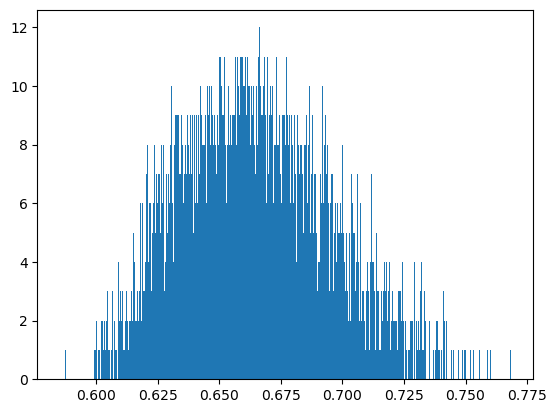

In [96]:
plt.hist(losses,bins=1000)[1]

In [101]:
import warnings
warnings.filterwarnings("ignore")

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]
a = [a[i] for i in range(0,len(a),1)]

lam = 1
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []


train_sse = []
test_sse = []


counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
    print(train_sse[-1],test_sse[-1],i+1,len(a))


    pred = np.argmax(p,axis=1)
    train_acc.append(f1_score(pred,y_train,average='macro'))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(f1_score(test_pred,y_test,average='macro'))


    # pred = np.argmax(p,axis=1)
    # train_acc.append(accuracy_score(pred,y_train))
    # test_pred = np.argmax(test_p,axis=1)
    # test_acc.append(accuracy_score(test_pred,y_test))

    print('\t',train_acc[-1],test_acc[-1],i+1,len(a))
    

48977.31511433254 49008.49721270387 1 4223
	 0.4939029446322259 0.4922940443237394 1 4223
37964.55948915083 38033.34018418066 2 4223
	 0.49043409252259085 0.48852350082418206 2 4223
31911.13542219358 32003.505751971934 3 4223
	 0.5125441504035676 0.509543680600856 3 4223
28410.946983510217 28531.822450125033 4 4223
	 0.5140466120213472 0.5103023338503444 4 4223
26206.004596787574 26367.421061300396 5 4223
	 0.5192951525114641 0.5152839641810231 5 4223
25174.122912395935 25349.568244668117 6 4223
	 0.5240111374783698 0.5205139551721004 6 4223
24312.33492457614 24500.680524074556 7 4223
	 0.531529817865745 0.5273333053096338 7 4223
23905.322357095738 24102.355648930337 8 4223
	 0.5302382910680256 0.5259713767246932 8 4223
23706.628587915395 23912.627019786327 9 4223
	 0.531171745460217 0.5271061699123212 9 4223
23409.906439852286 23618.242470540554 10 4223
	 0.5318215380500069 0.5280695188010498 10 4223
23301.08586432927 23520.789174784775 11 4223
	 0.5344452636751487 0.529975905374964 1

# Model Report

In [45]:
#balance acc
i = -1

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

11048 0.9303658143058682 0.6502346855626817


In [46]:
#balance acc
i = 300

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

4468 0.8258706008172882 0.6401503474454651


In [82]:
pred = np.argmax(p,axis=1)
print(classification_report(pred,y_train))
test_pred = np.argmax(test_p,axis=1)
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     11099
           1       0.37      0.80      0.50      2087
           2       0.94      0.84      0.89     29656
           3       0.83      0.89      0.86      5054
           4       0.73      0.86      0.79      5058

    accuracy                           0.84     52954
   macro avg       0.75      0.85      0.78     52954
weighted avg       0.87      0.84      0.85     52954

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     11300
           1       0.13      0.41      0.20      1461
           2       0.88      0.77      0.82     30242
           3       0.71      0.77      0.74      5007
           4       0.62      0.75      0.68      4944

    accuracy                           0.75     52954
   macro avg       0.63      0.69      0.64     52954
weighted avg       0.80      0.75      0.77     52954



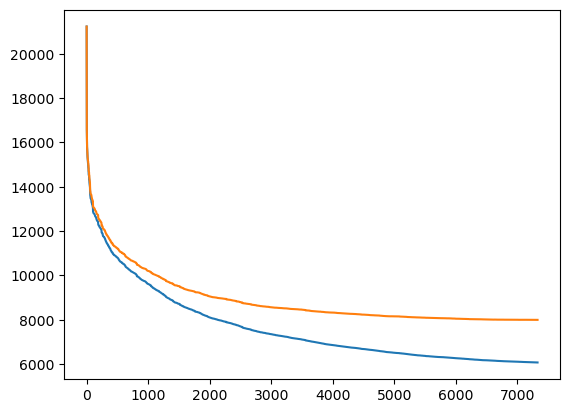

In [48]:
plt.plot(train_sse)
plt.plot(test_sse)

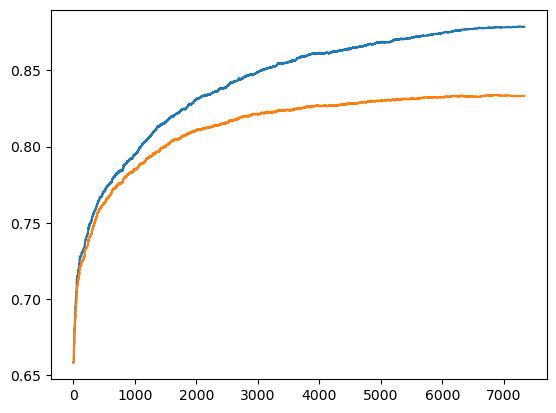

In [49]:
plt.plot(train_acc)
plt.plot(test_acc)

# Xgboost

In [65]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

# pred = xgb.predict_proba(X_train)
# pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=5))
print(balanced_accuracy_score(y_test,pred))

# pred = xgb.predict_proba(X_test)
# pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0      0.832     0.862     0.846     10680
           1      0.693     0.306     0.425      4526
           2      0.820     0.924     0.869     26349
           3      0.855     0.794     0.824      5416
           4      0.841     0.724     0.779      5983

    accuracy                          0.823     52954
   macro avg      0.808     0.722     0.748     52954
weighted avg      0.817     0.823     0.812     52954

              precision    recall  f1-score   support

           0    0.76823   0.80888   0.78803     10679
           1    0.44034   0.17366   0.24909      4526
           2    0.78851   0.89131   0.83676     26349
           3    0.79809   0.74003   0.76796      5416
           4    0.77261   0.66093   0.71242      5984

    accuracy                        0.77184     52954
   macro avg    0.71356   0.65496   0.67085     52954
weighted avg    0.75385   0.77184   0.75562     52954



NameError: name 'balanced_accuracy_score' is not defined